Adaptive Distances
==================

In this example we show how to use the adaptive distances feature of pyabc. Adaptive distances means that the distance function is not fixed or pre-defined, but evolves over time, depending on the observed summary statistics. This can be useful if different summary statistics are on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights can be adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented, but it is possible to define arbitrary adaptive distances via the DistanceFunction.update() method.

To illustrate this feature, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

The summary statistic ss1 is informative about the model parameters $\theta$, summary statistic ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant, and in addition already has a comparably high variance. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 7.870415756620119
INFO:History:Start <ABCSMC(id=13, start_time=2018-03-13 15:32:53.164526, end_time=None)>
INFO:ABC:t:0 eps:7.870415756620119
INFO:ABC:t:1 eps:4.806726157297115
INFO:ABC:t:2 eps:2.8575181011616078
INFO:ABC:t:3 eps:1.904369882979055
INFO:ABC:t:4 eps:1.3415918287301587
INFO:ABC:t:5 eps:0.9633777096808731
INFO:ABC:t:6 eps:0.7308390539197372
INFO:ABC:t:7 eps:0.5245452045516216
INFO:History:Done <ABCSMC(id=13, start_time=2018-03-13 15:32:53.164526, end_time=2018-03-13 15:33:32.122688)>


Let us visualize the results for the non-adaptive distance:

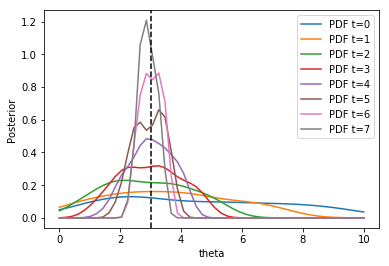

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.WeightedPNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.41240979206534245, 'ss2': 0.13497696391832373}
INFO:Epsilon:initial epsilon is 1.7278403037783294
INFO:History:Start <ABCSMC(id=16, start_time=2018-03-13 15:33:32.645244, end_time=None)>
INFO:ABC:t:0 eps:1.7278403037783294
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.4195059143271734, 'ss2': 0.13348196306362814}
INFO:ABC:t:1 eps:1.1245222175446947
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.6232513840575504, 'ss2': 0.14665964642346369}
INFO:ABC:t:2 eps:0.9362935601187451
DEBUG:DistanceFunction:update distance function weights = {'ss1': 1.018307856685198, 'ss2': 0.1547322466978927}
INFO:ABC:t:3 eps:0.8734506933656767
DEBUG:DistanceFunction:update distance function weights = {'ss1': 1.8278429762222002, 'ss2': 0.1334272016962799}
INFO:ABC:t:4 eps:0.7536405884365266
DEBUG:DistanceFunction:update distance function weights = {'ss1': 3.149871495495849, 'ss2': 0.1580116257549239}


In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

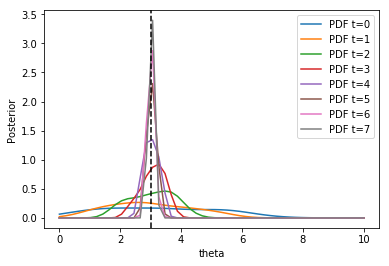

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe a slightly different result. The densitities tend to be narrower around the true parameter $\theta=3$, as anticipated.